Node SN1: RSSI = 1.01e-05
Node SN2: RSSI = 3.62e-06
Node SN3: RSSI = 4.53e-06
Node SN4: RSSI = 1.05e-05
Node SN5: RSSI = 3.49e-06
Node SN6: RSSI = 5.71e-06
Node SN7: RSSI = 1.08e-05
Node SN8: RSSI = 1.3e-05
Node SN9: RSSI = 4.49e-06
Node SN10: RSSI = 3.95e-06
Node SN11: RSSI = 4.38e-06
Node SN12: RSSI = 5.13e-06
Node SN13: RSSI = 1.33e-05
Node SN14: RSSI = 1.96e-05
Node SN15: RSSI = 7.44e-06
Node SN16: RSSI = 1.23e-05


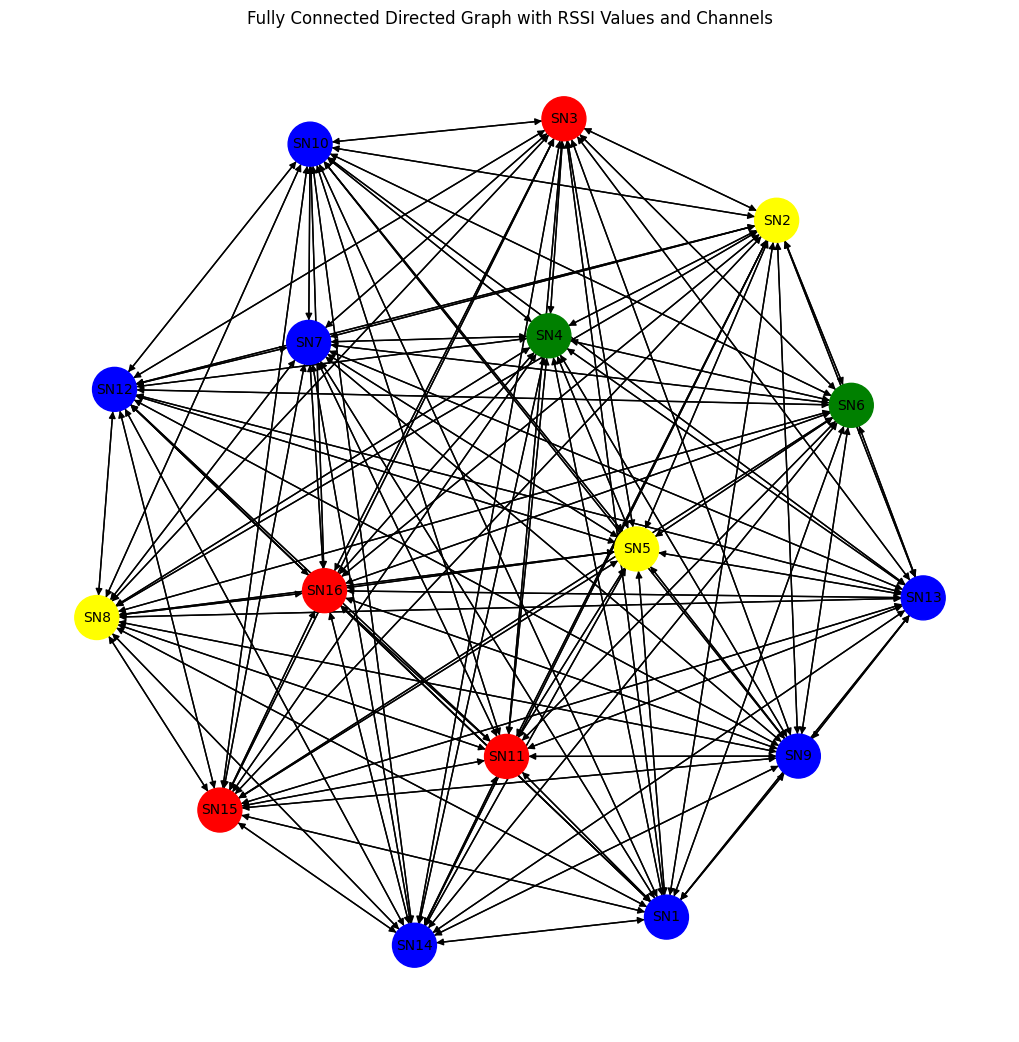

Channel 2: Nodes ['SN1', 'SN7', 'SN9', 'SN10', 'SN12', 'SN13', 'SN14']
Channel 3: Nodes ['SN2', 'SN5', 'SN8']
Channel 0: Nodes ['SN3', 'SN11', 'SN15', 'SN16']
Channel 1: Nodes ['SN4', 'SN6']
tensor([[-0.7997, -0.0567,  0.1291, -0.0705,  0.7092, -0.0470, -0.6419,  0.4756,
         -1.0162,  0.8176, -0.3450,  0.6125, -0.2210,  1.4872, -0.0076, -0.2599,
          0.6930,  0.3119,  0.2898, -0.2244, -0.4455,  0.6731,  0.2353, -0.1833,
         -0.1576,  0.0339,  0.1048,  0.0767,  0.1200,  0.1643,  1.2238,  0.0376,
         -0.6363, -0.1328,  0.1204,  0.3015, -1.4057, -0.5467, -0.2274, -0.5677,
          0.0056, -0.6535,  0.5818, -0.8276,  0.0945, -0.6295,  0.4640, -1.2219,
         -0.4006,  0.6038,  0.1673,  1.0725, -0.6114,  0.1630, -0.1739,  0.8412,
         -0.7500,  0.5460,  0.3839, -0.0285,  0.4515, -0.0959,  0.0170,  0.7782,
         -0.8354,  0.5332,  0.0100,  0.1000,  0.3078, -0.1952, -0.0157,  0.2300,
         -0.3922, -0.2942, -0.3345,  1.4296,  0.0980,  0.3175, -1.3334,  0.5587,

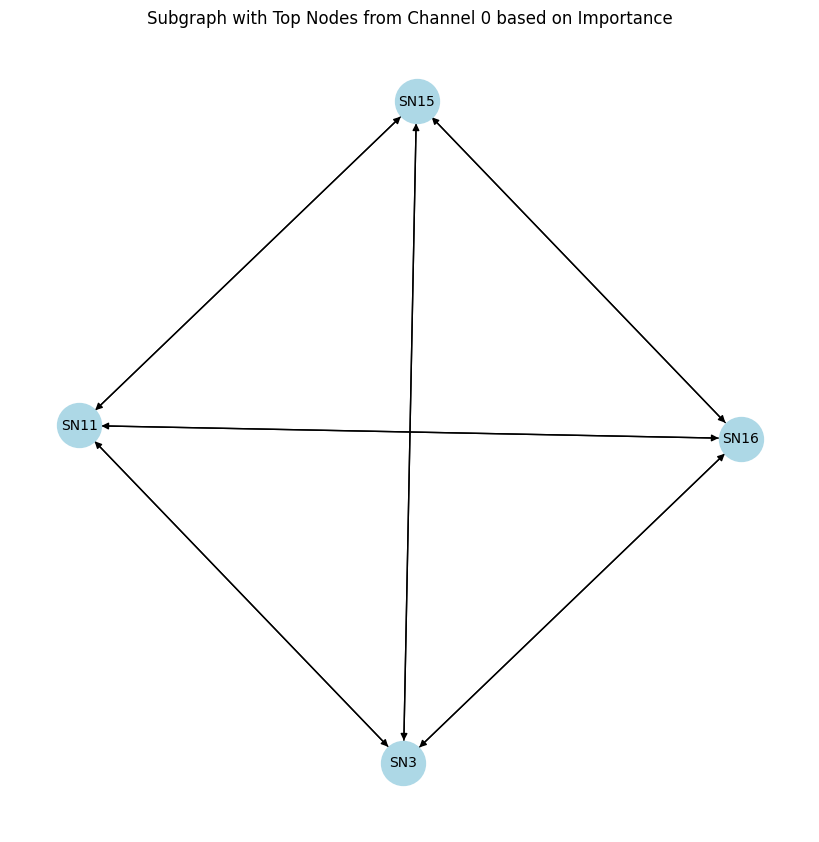

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f

# Assuming AttentionCritic and Args classes are already defined as per your previous code
class AttentionCritic(nn.Module):
    def __init__(self, input_shape, args):
        super(AttentionCritic, self).__init__()

        # Encoding
        self.encoding = nn.Linear(input_shape, args.rnn_hidden_dim)
        self.h = nn.GRUCell(args.rnn_hidden_dim, args.rnn_hidden_dim)
        self.hard_bi_GRU = nn.GRU(args.rnn_hidden_dim * 2, args.rnn_hidden_dim, bidirectional=True)
        self.hard_encoding = nn.Linear(args.rnn_hidden_dim * 2, 2)

        # Soft
        self.q = nn.Linear(args.rnn_hidden_dim, args.attention_dim, bias=False)
        self.k = nn.Linear(args.rnn_hidden_dim, args.attention_dim, bias=False)
        self.v = nn.Linear(args.rnn_hidden_dim, args.attention_dim)
        self.decoding = nn.Linear(args.rnn_hidden_dim + args.attention_dim, args.n_actions)

        self.args = args
        self.input_shape = input_shape

    def forward(self, obs, hidden_state):
        size = obs.shape[0]  # batch_size * n_agents
        obs_encoding = f.relu(self.encoding(obs))
        h_in = hidden_state.reshape(-1, self.args.rnn_hidden_dim)
        h_out = self.h(obs_encoding, h_in)

        # Hard Attention
        if self.args.hard:
            hard_weights = self.hard_attention(h_out, size)
        else:
            hard_weights = torch.ones((self.args.n_agents, size // self.args.n_agents, 1, self.args.n_agents - 1))
            if self.args.cuda:
                hard_weights = hard_weights.cuda()

        # Soft Attention
        soft_output = self.soft_attention(h_out, hard_weights, size)

        # Combining with decoding
        final_input = torch.cat([h_out, soft_output], dim=-1)
        print(final_input)

        output = self.decoding(final_input)

        return output, h_out

    def hard_attention(self, h_out, size):
        #print("Shape of h_out before reshaping:", h_out.shape)
        
        new_shape = [size // self.args.n_agents, self.args.n_agents, self.args.rnn_hidden_dim]
        h = h_out.reshape(new_shape)


        #h = h_out.reshape(-1, self.args.n_agents, self.args.rnn_hidden_dim)  
        input_hard = []
        for i in range(self.args.n_agents):
            h_i = h[:, i]  # (batch_size, rnn_hidden_dim)
            h_hard_i = []
            for j in range(self.args.n_agents):  
                if j != i:
                    h_hard_i.append(torch.cat([h_i, h[:, j]], dim=-1))
              
            h_hard_i = torch.stack(h_hard_i, dim=0)
            input_hard.append(h_hard_i)
            
        input_hard = torch.stack(input_hard, dim=-2)
            
        input_hard = input_hard.view(self.args.n_agents - 1, -1, self.args.rnn_hidden_dim * 2)
        h_hard = torch.zeros((2 * 1, size, self.args.rnn_hidden_dim))  
        if self.args.cuda:
            h_hard = h_hard.cuda()
        h_hard, _ = self.hard_bi_GRU(input_hard, h_hard)  
        h_hard = h_hard.permute(1, 0, 2)  # (batch_size * n_agents, n_agents - 1, rnn_hidden_dim * 2)
        h_hard = h_hard.reshape(-1, self.args.rnn_hidden_dim * 2)  # (batch_size * n_agents * (n_agents - 1), rnn_hidden_dim * 2)

           
        hard_weights = self.hard_encoding(h_hard)
        hard_weights = f.gumbel_softmax(hard_weights, tau=0.01)
        #print(hard_weights)
        hard_weights = hard_weights[:, 1].view(-1, self.args.n_agents, 1, self.args.n_agents - 1)
        hard_weights = hard_weights.permute(1, 0, 2, 3)
       
        return hard_weights
       
    def soft_attention(self, h_out, hard_weights, size):
        q = self.q(h_out)
        k = self.k(h_out)
        v = f.relu(self.v(h_out))

        # Assume each item in the batch is separate (not splitting into agents)
        batch_size = q.shape[0]

        x = []
        for i in range(batch_size):
            q_i = q[i].view(1, self.args.attention_dim)
            k_i = k[i].view(1, self.args.attention_dim)
            v_i = v[i].view(1, self.args.attention_dim)

            # Scaled dot-product attention
            score = torch.matmul(q_i, k_i.T)
            scaled_score = score / np.sqrt(self.args.attention_dim)
            soft_weight = f.softmax(scaled_score, dim=-1)

            x_i = v_i * soft_weight
            x.append(x_i)

        x = torch.stack(x, dim=0).reshape(batch_size, self.args.attention_dim)
        return x

#Define Parameters and Model

class Args:
    def __init__(self):
        self.rnn_hidden_dim = 128  # example value
        self.attention_dim = 64    # example value
        self.n_actions = 10        # example value
        self.n_agents = 5          # example value
        self.cuda = False         # set to True if using GPU
        self.hard = False  
        self.input_shape = 256 


# Load the CSV data
data = pd.read_csv('C:\\Reinforcement_learning\\centralized_dataset_interference_all_riadv1_0_22_2024_update1.csv')

# Create a directed graph
G = nx.DiGraph()

# Define nodes based on the "SN" column
nodes = data['SN'].tolist()

# Add nodes to the graph and set RSSI values as node attributes
for node in nodes:
    G.add_node(node, RSSI=data.loc[data['SN'] == node, 'RSSI'].values[0])

# Connect each node to every other node
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if i != j:
            G.add_edge(nodes[i], nodes[j])

# Define your channel array
channel_array = [2, 3, 0, 1, 3, 1, 2, 3, 2, 2, 0, 2, 2, 2, 0, 0]

# Map each node to its channel
node_channel_map = {node: channel for node, channel in zip(nodes, channel_array)}

# Group nodes by channel
channel_groups = {}
for node, channel in node_channel_map.items():
    if channel not in channel_groups:
        channel_groups[channel] = []
    channel_groups[channel].append(node)

# Visualize the graph
plt.figure(figsize=(10, 10))

# Node colors based on channels
colors = ['red', 'green', 'blue', 'yellow']
node_colors = [colors[node_channel_map[node]] for node in G.nodes]

# Draw the graph
nx.draw(G, with_labels=True, node_size=1000, font_size=10, node_color=node_colors, arrows=True)

# Add labels for RSSI values
#rssi_labels = {node: f"{G.nodes[node]['RSSI']}" for node in G.nodes}
#pos = nx.spring_layout(G)  # positions for all nodes
#nx.draw_networkx_labels(G, pos, labels=rssi_labels, font_size=12, font_color='black')

#Print RSSI values for every nodes
for node in G.nodes:
    rssi_value = G.nodes[node]['RSSI']
    print(f"Node {node}: RSSI = {rssi_value}")
plt.title("Fully Connected Directed Graph with RSSI Values and Channels")
plt.show()

# Print channel groups
for channel, nodes in channel_groups.items():
    print(f"Channel {channel}: Nodes {nodes}")

# Create adjacency matrix from the graph
adjacency_matrix = nx.to_numpy_array(G)

# Initialize the AttentionCritic model
args = Args()
model = AttentionCritic(args.input_shape, args)  # Adjusted to use args.input_shape

# Process the adjacency matrix and hidden state
processed_adj_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32).view(1, -1)  # Flatten the matrix
hidden_state = torch.randn(1, args.rnn_hidden_dim)

# Pass the processed adjacency matrix through the model
output, _ = model(processed_adj_matrix, hidden_state)


#output_values = output.detach().numpy().flatten()

# Lower the threshold
threshold = 0.5  # Adjusted to a lower value for demonstration

# Process the adjacency matrix and hidden state
processed_adj_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32).view(1, -1)
hidden_state = torch.randn(1, args.rnn_hidden_dim)

# Pass the processed adjacency matrix through the model
output, new_hidden_state = model(processed_adj_matrix, hidden_state)
print("Output shape:", output.shape)
print("Output:", output)
print("New Hidden State shape:", new_hidden_state.shape)
print("New Hidden State:", new_hidden_state)

# Assuming the model's output is now a measure of node importance, 
# # use it to select the top 4 nodes
# importance_scores = output.detach().numpy().flatten()
# top_node_indices = np.argsort(importance_scores)[-4:]  # Indices of the top 4 nodes
# top_node_names = [nodes[i] for i in top_node_indices]

# # Create a subgraph with the top 4 nodes
# subG = G.subgraph(top_node_names)

# # Visualize the subgraph
# plt.figure(figsize=(8, 8))
# nx.draw(subG, with_labels=True, node_size=1000, font_size=10, node_color='lightblue', arrows=True)
# plt.title("Subgraph with Top 4 Nodes based on Model Output")
# plt.show()

#For debugging 
#print("Output tensor shape:", output.shape)

def calculate_node_importance(output, G, channel, default_importance=0):
    importance_scores = output.detach().numpy().flatten()

    # Create a dictionary to hold node importance...
    node_importance = {node: default_importance for node in G.nodes if node_channel_map[node] == channel}

    # Update importance for nodes for which we have scores
    for i, node in enumerate(G.nodes):
        if node_channel_map[node] == channel and i < len(importance_scores):
            node_importance[node] = importance_scores[i] * G.nodes[node]['RSSI']

    return node_importance
# Select a specific channel
selected_channel = 0

# Calculate node importance for nodes in the selected channel
node_importance = calculate_node_importance(output, G, selected_channel)

# Select the top nodes based on importance
top_nodes = sorted(node_importance, key=node_importance.get, reverse=True)[:4]  # Top 4 nodes

# Create a subgraph with these top nodes
subG = G.subgraph(top_nodes)

# Visualize the subgraph
plt.figure(figsize=(8, 8))
nx.draw(subG, with_labels=True, node_size=1000, font_size=10, node_color='lightblue', arrows=True)
plt.title(f"Subgraph with Top Nodes from Channel {selected_channel} based on Importance")
plt.show()